Epoch 1/20
61/61 - 6s - loss: 9.3219 - accuracy: 0.4669 - val_loss: 1.0081 - val_accuracy: 0.5620 - 6s/epoch - 93ms/step
Epoch 2/20
61/61 - 4s - loss: 0.8831 - accuracy: 0.6386 - val_loss: 0.8442 - val_accuracy: 0.6705 - 4s/epoch - 70ms/step
Epoch 3/20
61/61 - 4s - loss: 0.5904 - accuracy: 0.7575 - val_loss: 0.7305 - val_accuracy: 0.7326 - 4s/epoch - 70ms/step
Epoch 4/20
61/61 - 4s - loss: 0.3738 - accuracy: 0.8666 - val_loss: 0.6362 - val_accuracy: 0.7961 - 4s/epoch - 70ms/step
Epoch 5/20
61/61 - 4s - loss: 0.2298 - accuracy: 0.9188 - val_loss: 0.7739 - val_accuracy: 0.7798 - 4s/epoch - 70ms/step
Epoch 6/20
61/61 - 4s - loss: 0.1229 - accuracy: 0.9560 - val_loss: 0.7123 - val_accuracy: 0.8132 - 4s/epoch - 70ms/step
41/41 - 1s - loss: 0.7123 - accuracy: 0.8132 - 535ms/epoch - 13ms/step

Loss: 0.7123229503631592
Accuracy: 0.813178300857544
41/41 [==============================] - 0s 11ms/step
Train Loss:  [9.321858406066895, 0.8830763101577759, 0.5903913378715515, 0.37380918860435486, 0

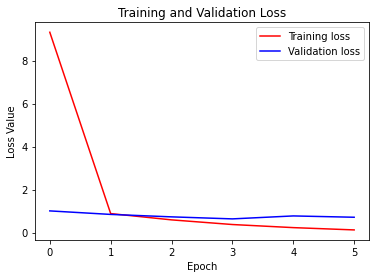

In [8]:
import cv2
import numpy as np
import os
import sys
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

EPOCHS = 20
IMG_WIDTH = 30
IMG_HEIGHT = 30
TUMOR_CLASSES = ["category1_tumor", "category2_tumor", "category3_tumor", "no_tumor"]
TEST_SIZE = 0.4
DIRECTORY = "../Datathon-Dataset"


def main():

    # Get image arrays and labels for all image files
    images, labels = load_data(DIRECTORY)

    # Split data into training and testing sets
    labels = tf.keras.utils.to_categorical(labels)
    x_train, x_test, y_train, y_test = train_test_split(
        np.array(images), np.array(labels), test_size=TEST_SIZE
    )

    # Get a compiled neural network
    model = get_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=2)
    # Fit model on training data
    history = model.fit(x_train, y_train, epochs=EPOCHS, callbacks=[early_stopping], validation_split=0.2, 
              validation_data=(x_test, y_test), verbose=2)

    # Evaluate neural network performance
    loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
    print(f"\nLoss: {loss}")
    print(f"Accuracy: {accuracy}")

    predictions = model.predict(x_test)
    y_pred = np.argmax(predictions, axis=1)
    y_test = np.argmax(y_test, axis=1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    print("Train Loss: ", train_loss)
    print("Validation Loss: ", val_loss)
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred, average='weighted'))
    print("Precision: ", precision_score(y_test, y_pred, average='weighted'))
    print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print("Model Summary: ")
    model.summary()

    #plot the training and validation accuracy and loss at each epoch and add a title and axis labels and legend
    epochs = range(len(train_loss))
    plt.plot(epochs, train_loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.show()



    # Save model to file
    if len(sys.argv) == 2:
        filename = sys.argv[2]
        model.save(filename)
        print(f"Model saved to {filename}.")


def load_data(base_path):

    images = []
    labels = []

    for i, tumor_class in enumerate(TUMOR_CLASSES):
        class_path = os.path.join(base_path, tumor_class)

        for filename in os.listdir(class_path):
            if filename.endswith(".jpg"):
                img = cv2.imread(os.path.join(class_path, filename))
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                images.append(img)
                labels.append(i)
    return images, labels


def get_model():
    layers = [
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation="relu"),

        # Flatten units
        tf.keras.layers.Flatten(),

        # Add hidden layers with dropout
        tf.keras.layers.Dense(512, activation="relu"),
 #       tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation="relu"),
#        tf.keras.layers.Dropout(0.5),

        # Output layer
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
    model = tf.keras.models.Sequential(layers)
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model


if __name__ == "__main__":
    main()
